# YOLOv8 Training on People Detection Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install ultralytics roboflow opencv-python matplotlib
!pip install torch torchvision



Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 120.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [22]:
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from collections import Counter
import random
from PIL import Image, ImageDraw
import ultralytics
from pathlib import Path


# Download and prepare dataset

The dataset is in Pascal VOC format, and needs to be converted to YOLO format.

In [3]:
# Downloading and unzipping the dataset
!mkdir -p /content/datasets
!mkdir -p /content/datasets/people_detection

!curl -L -o /content/datasets/people_detection.zip https://www.kaggle.com/api/v1/datasets/download/adilshamim8/people-detection

!unzip -q /content/datasets/people_detection -d /content/datasets/people_detection/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1990M  100 1990M    0     0   117M      0  0:00:16  0:00:16 --:--:--  178M


## View the annotations

Training Dataset Annotations

In [19]:
df = pd.read_csv("/content/datasets/people_detection/train/train/_annotations.csv")
df.head()

filename  width  height   class  \
0  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
1  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
2  2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375  person   
3  004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333  person   
4  004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333  person   

   xmin  ymin  xmax  ymax  
0   219    98   269   283  
1   114   124   155   263  
2    43   139    98   340  
3   145   118   229   333  
4   285   105   349   329

Test Dataset Annotations

In [20]:

df = pd.read_csv("/content/datasets/people_detection/test/test/_annotations.csv")
df.head()



filename  width  height   class  \
0  0002640_jpg.rf.a1f2d386da1e4821651f9dec0cf5254...   1280     964  person   
1  2007_006841_jpg.rf.cdc00183ebc2771e932eb4f907e...    500     316  person   
2  2007_006841_jpg.rf.cdc00183ebc2771e932eb4f907e...    500     316  person   
3  2008_002523_jpg.rf.0504a335ef96ee9f9ac5153b237...    500     375  person   
4  2007_004065_jpg.rf.99a8c0f81203b9368f6938238b1...    500     375  person   

   xmin  ymin  xmax  ymax  
0   165   511   217   642  
1   385   105   435   283  
2   488   117   499   215  
3   232    10   369   180  
4   451   187   474   244

Validation Dataset Annotations

In [21]:
df = pd.read_csv("/content/datasets/people_detection/valid/valid/_annotations.csv")
df.head()

filename  width  height   class  \
0  BSMT1XOO121P_jpg.rf.3172b37162bba43942f1a82395...    500     375  person   
1  point03_140_png_jpg.rf.4166a3ba6f32cf3fad662d2...   1280     720  person   
2  point03_140_png_jpg.rf.4166a3ba6f32cf3fad662d2...   1280     720  person   
3  point01_179_png_jpg.rf.4b397a9403192a0c286c5f3...   1280     720  person   
4  2010_003325_jpg.rf.9caa17b2dd1dade077477d4ae80...    500     375  person   

   xmin  ymin  xmax  ymax  
0   254   136   350   304  
1   406   138   609   488  
2   681     0   711   101  
3   836   244   976   579  
4   213    40   476   316

## Reorganise dataset to YOLO format

In [28]:
# 1. Convert CSV to YOLO format (automated)
def create_yolo_dataset_from_csv(csv_paths, image_dirs, output_base_dir):
    """
    Convert CSV dataset to YOLO format
    """
    output_base = Path(output_base_dir)
    output_base.mkdir(exist_ok=True)

    for split in ['train', 'val', 'test']:
        # Read CSV
        df = pd.read_csv(csv_paths[split])
        print(df)

        # Create directories
        img_dir = output_base / split / 'images'
        label_dir = output_base / split / 'labels'
        img_dir.mkdir(parents=True, exist_ok=True)
        label_dir.mkdir(parents=True, exist_ok=True)

        # Process each image
        for img_name, row in df.groupby('filename').first().iterrows():
            src_img = Path(image_dirs[split]) / img_name

            if src_img.exists():
                # Copy image
                shutil.copy(src_img, img_dir / img_name)

                # Create YOLO annotation
                img_annotations = df[df['filename'] == img_name]
                txt_path = label_dir / f"{Path(img_name).stem}.txt"

                with open(txt_path, 'w') as f:
                    for _, ann in img_annotations.iterrows():
                        # Convert to YOLO format
                        x_center = (ann['xmin'] + ann['xmax']) / 2 / ann['width']
                        y_center = (ann['ymin'] + ann['ymax']) / 2 / ann['height']
                        width = (ann['xmax'] - ann['xmin']) / ann['width']
                        height = (ann['ymax'] - ann['ymin']) / ann['height']

                        f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Processed {split}: {len(os.listdir(img_dir))} images")

    # Create data.yaml
    yaml_content = f"""path: {output_base}
train: train/images
val: val/images
test: test/images

nc: 1  # number of classes
names: ['face']  # changed from 'person' to 'face'

# Dataset statistics
# train: {len(os.listdir(output_base / 'train' / 'images'))} images
# val: {len(os.listdir(output_base / 'val' / 'images'))} images
# test: {len(os.listdir(output_base / 'test' / 'images'))} images
"""

    with open(output_base / 'data.yaml', 'w') as f:
        f.write(yaml_content)

    return output_base

In [29]:
csv_paths = {
    'train': '/content/datasets/people_detection/train/train/_annotations.csv',
    'val': '/content/datasets/people_detection/valid/valid/_annotations.csv',
    'test': '/content/datasets/people_detection/test/test/_annotations.csv'
}

image_dirs = {
    'train': '/content/datasets/people_detection/train/train',
    'val': '/content/datasets/people_detection/valid/valid',
    'test': '/content/datasets/people_detection/test/test'
}

output_base_dir = '/content/datasets/people_detection_yolo'

# Run the conversion
yolo_dataset_path = create_yolo_dataset_from_csv(csv_paths, image_dirs, output_base_dir)
print(f"YOLO dataset created at: {yolo_dataset_path}")

                                                 filename  width  height  \
0       2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375   
1       2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375   
2       2008_003132_jpg.rf.92f6223defec4f57f2d7b9cfa28...    500     375   
3       004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333   
4       004574_jpg.rf.7c8cea69d7be45f58febcede26ef0c6e...    500     333   
...                                                   ...    ...     ...   
100077  2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...   4410    3308   
100078  2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...   4410    3308   
100079  2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...   4410    3308   
100080  2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...   4410    3308   
100081  2008_007145_jpg.rf.99fc120cdee10b38fe50fe80989...   4410    3308   

         class  xmin  ymin  xmax  ymax  
0       person   219    98   269   283  
1    

## Check dataset

Training annotations: 100082
Test annotations: 2783
Validation annotations: 10683

Training images: 15210
Test images: 760
Validation images: 1431
First training image:


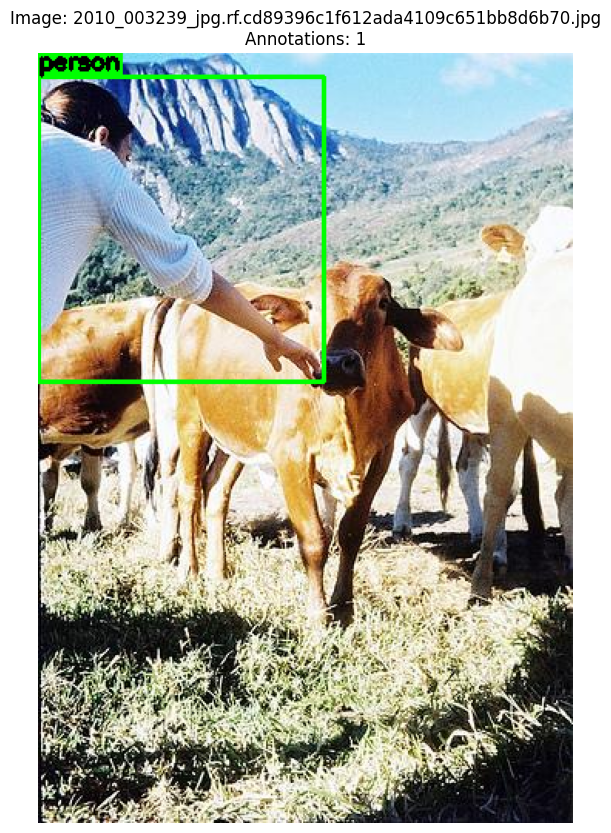

Image: 2010_003239_jpg.rf.cd89396c1f612ada4109c651bb8d6b70.jpg
Dimensions: 347x500
Number of people detected: 1

Bounding boxes:
  Person: [0, 15, 185, 213]
--------------------------------------------------

Random training samples:

Sample 1/3:


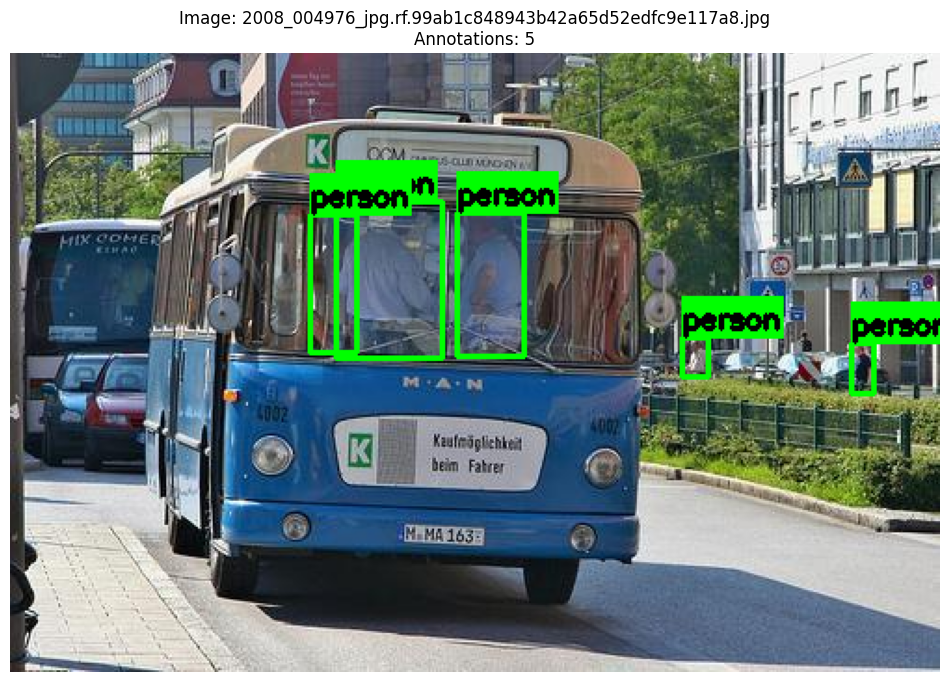

Image: 2008_004976_jpg.rf.99ab1c848943b42a65d52edfc9e117a8.jpg
Dimensions: 500x333
Number of people detected: 5

Bounding boxes:
  Person: [361, 153, 375, 174]
  Person: [452, 156, 464, 183]
  Person: [240, 86, 276, 163]
  Person: [175, 80, 232, 164]
  Person: [161, 87, 186, 161]
--------------------------------------------------

Sample 2/3:


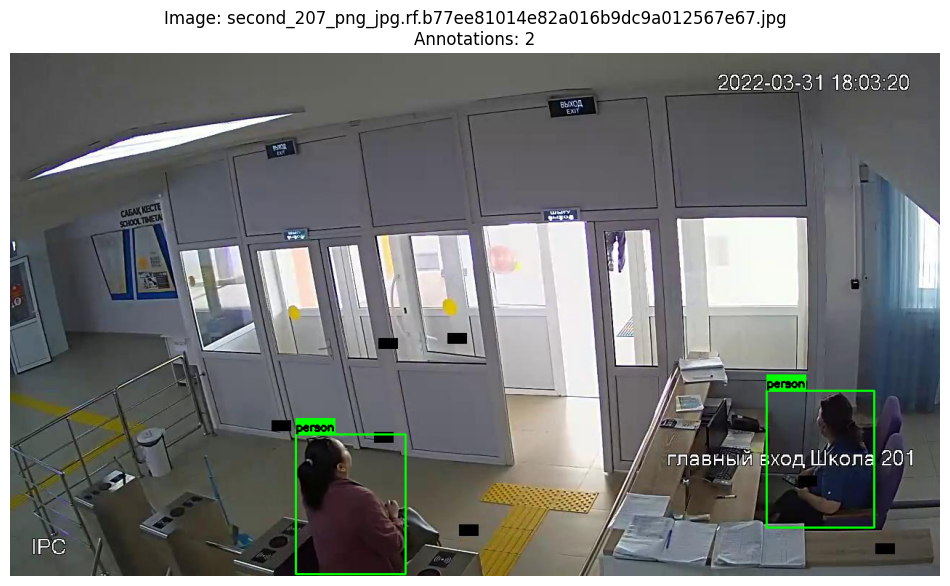

Image: second_207_png_jpg.rf.b77ee81014e82a016b9dc9a012567e67.jpg
Dimensions: 1280x720
Number of people detected: 2

Bounding boxes:
  Person: [393, 525, 544, 717]
  Person: [1041, 465, 1189, 653]
--------------------------------------------------

Sample 3/3:


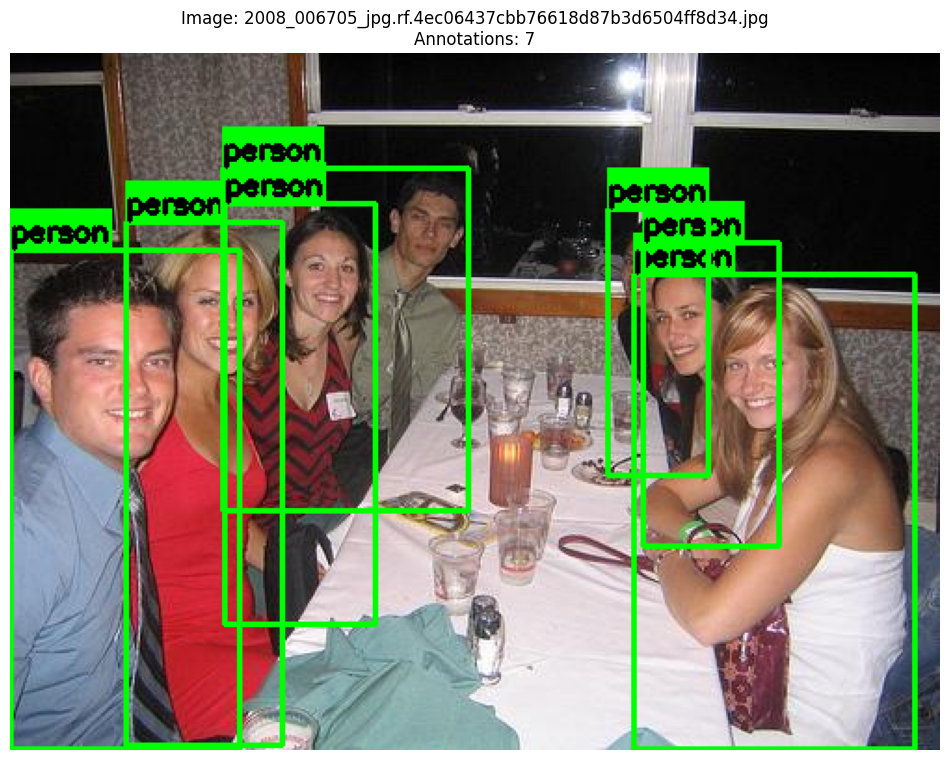

Image: 2008_006705_jpg.rf.4ec06437cbb76618d87b3d6504ff8d34.jpg
Dimensions: 500x375
Number of people detected: 7

Bounding boxes:
  Person: [0, 106, 123, 374]
  Person: [62, 91, 146, 372]
  Person: [115, 81, 196, 307]
  Person: [114, 62, 246, 246]
  Person: [335, 119, 486, 374]
  Person: [340, 102, 413, 265]
  Person: [321, 84, 375, 227]
--------------------------------------------------


In [31]:
import glob

train_labels = pd.read_csv("/content/datasets/people_detection/train/train/_annotations.csv")
test_labels = pd.read_csv("/content/datasets/people_detection/test/test/_annotations.csv")
val_labels = pd.read_csv("/content/datasets/people_detection/valid/valid/_annotations.csv")

print(f"Training annotations: {len(train_labels)}")
print(f"Test annotations: {len(test_labels)}")
print(f"Validation annotations: {len(val_labels)}")

train_images = glob.glob('/content/datasets/people_detection/train/train/*.jpg')
test_images = glob.glob('/content/datasets/people_detection/test/test/*.jpg')
val_images = glob.glob('/content/datasets/people_detection/valid/valid/*.jpg')

print(f"\nTraining images: {len(train_images)}")
print(f"Test images: {len(test_images)}")
print(f"Validation images: {len(val_images)}")


# Display sample image with annotations from CSV
def show_sample(image_path, labels_df):
    """
    Display image with bounding boxes from CSV annotations

    Args:
        image_path: Path to the image file
        labels_df: DataFrame containing annotations for all images
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not load image: {image_path}")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get filename from path
    filename = os.path.basename(image_path)

    # Filter annotations for this specific image
    img_annotations = labels_df[labels_df['filename'] == filename]

    if not img_annotations.empty:
        for _, row in img_annotations.iterrows():
            # Get bounding box coordinates from CSV
            x1 = int(row['xmin'])
            y1 = int(row['ymin'])
            x2 = int(row['xmax'])
            y2 = int(row['ymax'])
            class_name = row['class']

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add label text
            label = f"{class_name}"
            # Get text size for background rectangle
            (text_width, text_height), baseline = cv2.getTextSize(
                label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
            )

            # Draw background rectangle for text
            cv2.rectangle(
                img,
                (x1, y1 - text_height - 10),
                (x1 + text_width, y1),
                (0, 255, 0),
                -1  # Filled rectangle
            )

            # Add text
            cv2.putText(
                img,
                label,
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 0, 0),  # Black text
                2
            )

    # Display image
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')

    # Add title with annotation count
    num_annotations = len(img_annotations)
    plt.title(f"Image: {filename}\nAnnotations: {num_annotations}")
    plt.show()

    # Print annotation details
    print(f"Image: {filename}")
    print(f"Dimensions: {img.shape[1]}x{img.shape[0]}")
    print(f"Number of people detected: {num_annotations}")

    if not img_annotations.empty:
        print("\nBounding boxes:")
        for _, row in img_annotations.iterrows():
            print(f"  Person: [{row['xmin']}, {row['ymin']}, {row['xmax']}, {row['ymax']}]")

    print("-" * 50)

# Display multiple samples
def show_multiple_samples(image_paths, labels_df, num_samples=3):
    """Display multiple sample images"""
    import random

    if len(image_paths) < num_samples:
        num_samples = len(image_paths)

    sampled_paths = random.sample(image_paths, num_samples)

    for i, img_path in enumerate(sampled_paths, 1):
        print(f"\nSample {i}/{num_samples}:")
        show_sample(img_path, labels_df)

# Display a sample from training set
if train_images:
    img_path = train_images[0]
    print("First training image:")
    show_sample(img_path, train_labels)

# Display random samples
print("\nRandom training samples:")
show_multiple_samples(train_images, train_labels, num_samples=3)


# Initialize and train YOLO8 model

In [10]:
# Load pretrained YOLOv8 model
model = YOLO('yolov8n.pt')  # Can also use 'yolov8s.pt', 'yolov8m.pt', etc.

# Step 9: Train the model
# Training parameters
train_args = {
    'data': '/content/datasets/people_detection/data.yaml',
    'epochs': 100,
    'imgsz': 640,
    'batch': 16,
    'workers': 2,
    'device': 'cpu',  # Changed device from 0 to 'cpu'
    'save': True,
    'save_period': 10,
    'cache': False,
    'project': '/content/results',
    'name': 'people_detection',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'auto',
    'lr0': 0.01,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3.0,
    'warmup_momentum': 0.8,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'patience': 50,
    'freeze': None,  # You can freeze first N layers: freeze=10
    'resume': False
}

results = model.train(**train_args)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.30GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/people_detection/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=people_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspec

KeyboardInterrupt: 